## Chapter 09 텍스트를 위한 인공 신경망 ▶️한빛 마켓의 댓글을 분석하라!
#### 09-3 LSTM과 GRU 셀 ▶️순환 신경망의 중요 기술을 사용해 모델 만들어 보기
--- 
- simpleRNN은 긴 시퀀스를 학습하기 어려움. layer가 깊어질 수록 정보가 점차 희석되기 때문 (-> LSTM과 GRU 대두)
- LSTM(Long short term memory) : 순환되는 상태가 2개. 입력과 은닉층의 계산 외에 셀 상태의 계산이(4개) 추가된다. 
- GRU(Gated Recurrent Unit) : LSTM의 간소화 버전. LSTM 대비 가중치가 적어 계산이 빠른데도 불구 성능은 비슷한 것으로 알려짐 
- 참고문헌 1 : https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr 
- 참고문헌 2 : https://blog.naver.com/winddori2002/221992543837

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb 

# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [2]:
## loading the dataset, and split train/test sets 
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words = 1000)

print('1.train input 형태 : ', train_input.shape)
print('2.train target 형태 : ', train_target.shape)
print('3.test input 형태 : ', test_input.shape)
print('4.test target 형태 : ', test_target.shape)

1.train input 형태 :  (25000,)
2.train target 형태 :  (25000,)
3.test input 형태 :  (25000,)
4.test target 형태 :  (25000,)


In [3]:
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size = 0.2)

print('5.train input 형태 : ', train_input.shape)
print('6.train target 형태 : ', train_target.shape)
print('7.val input 형태 : ', val_input.shape)
print('8.val target 형태 : ', val_target.shape)

5.train input 형태 :  (20000,)
6.train target 형태 :  (20000,)
7.val input 형태 :  (5000,)
8.val target 형태 :  (5000,)


In [4]:
## all sample's length = 100 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
train_seq = pad_sequences(train_input, maxlen = 100)
val_seq = pad_sequences(val_input, maxlen = 100)

--- 
#### 1. LTSM 
- simpleRNN 대신 LSTM 사용. 은닉층의 셀안에 4개의 작은셀이 있으므로 simpleRNN에 비해 파라미터 수가 4배로 증가함

In [5]:
model = keras.Sequential()
model.add(keras.layers.Embedding(1000, 16, input_length = 100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           16000     
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 16,809
Trainable params: 16,809
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = 'accuracy')
check_point_callback = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only=True)
early_stopping_callback = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model.fit(train_seq, train_target, epochs = 100, batch_size = 64,
                    validation_data = (val_seq, val_target), 
                    callbacks = [check_point_callback, early_stopping_callback] )

Epoch 1/100
313/313 [==============================] - 7s 17ms/step - loss: 0.6922 - accuracy: 0.5454 - val_loss: 0.6914 - val_accuracy: 0.5634
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6892 - accuracy: 0.6074 - val_loss: 0.6872 - val_accuracy: 0.6156
Epoch 3/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6808 - accuracy: 0.6645 - val_loss: 0.6736 - val_accuracy: 0.6552
Epoch 4/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6376 - accuracy: 0.7165 - val_loss: 0.6031 - val_accuracy: 0.7358
Epoch 5/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5761 - accuracy: 0.7511 - val_loss: 0.5662 - val_accuracy: 0.7516
Epoch 6/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5457 - accuracy: 0.7669 - val_loss: 0.5381 - val_accuracy: 0.7664
Epoch 7/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5176 - accuracy: 0.7813 - val_loss: 0.5135 - val_accuracy:

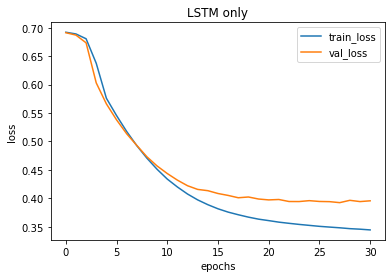

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM only')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

- simpleRNN에 비해 LSTM이 효과적으로 overfitting을 제어하고 있다. 
--- 
#### 2. LSTM with Dropout 

In [8]:
## hidden layer add & 30%의 dropout을 적용
## 첫번째 은닉층의 계산값을 다음 층으로 전달해줘야 하므로, return_sequences=True
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(1000, 16, input_length = 100))
model2.add(keras.layers.LSTM(8, dropout = 0.3, return_sequences=True))
model2.add(keras.layers.LSTM(8, dropout = 0.3))
model2.add(keras.layers.Dense(1, activation = 'sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           16000     
                                                                 
 lstm_1 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,353
Trainable params: 17,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
model2.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = 'accuracy')
check_point_callback = keras.callbacks.ModelCheckpoint('best-lstm-dropout-model.h5', save_best_only=True)
early_stopping_callback = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history2 = model2.fit(train_seq, train_target, epochs = 100, batch_size = 64,
                    validation_data = (val_seq, val_target), 
                    callbacks = [check_point_callback, early_stopping_callback] )

Epoch 1/100
313/313 [==============================] - 13s 33ms/step - loss: 0.6926 - accuracy: 0.5462 - val_loss: 0.6919 - val_accuracy: 0.5926
Epoch 2/100
313/313 [==============================] - 10s 32ms/step - loss: 0.6887 - accuracy: 0.6302 - val_loss: 0.6834 - val_accuracy: 0.6362
Epoch 3/100
313/313 [==============================] - 10s 32ms/step - loss: 0.6531 - accuracy: 0.6827 - val_loss: 0.6109 - val_accuracy: 0.7400
Epoch 4/100
313/313 [==============================] - 10s 32ms/step - loss: 0.5770 - accuracy: 0.7404 - val_loss: 0.5479 - val_accuracy: 0.7554
Epoch 5/100
313/313 [==============================] - 10s 32ms/step - loss: 0.5351 - accuracy: 0.7598 - val_loss: 0.5149 - val_accuracy: 0.7730
Epoch 6/100
313/313 [==============================] - 10s 33ms/step - loss: 0.5073 - accuracy: 0.7755 - val_loss: 0.4906 - val_accuracy: 0.7860
Epoch 7/100
313/313 [==============================] - 10s 32ms/step - loss: 0.4834 - accuracy: 0.7908 - val_loss: 0.4730 - val_ac

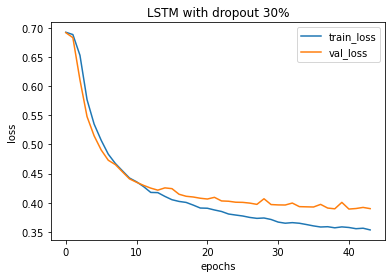

In [10]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('LSTM with dropout 30%')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [11]:
## 모델의 성능 보기, test_input에도 train_input과 마찬가지로 padding이 적용되어야 한다. 
test_seq = pad_sequences(test_input, maxlen = 100)
eval_model1 = keras.models.load_model('best-lstm-model.h5')
eval_model2 = keras.models.load_model('best-lstm-dropout-model.h5')

print('Model 1 - LSTM Only = ' , eval_model1.evaluate(test_seq, test_target))
print('Model 2 - LSTM with 2 layers & dropout 0.3 = ' , eval_model2.evaluate(test_seq, test_target))

782/782 [==============================] - 3s 4ms/step - loss: 0.3863 - accuracy: 0.8271
Model 1 - LSTM Only =  [0.38628751039505005, 0.8270800113677979]
782/782 [==============================] - 6s 7ms/step - loss: 0.3810 - accuracy: 0.8275
Model 2 - LSTM with 2 layers & dropout 0.3 =  [0.3810323178768158, 0.8275200128555298]


- 보통 layer를 추가하고, dropout을 적용하면 모델 성능은 개선되면서 overfitting은 제어된다. 
- (본 예제에서는 데이터가 비교적 심플하여 model1, model2의 차이가 크지 않았음)
--- 
#### 3. GRU 
- LSTM 대신 GRU 사용 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           16000     
                                                                 
 gru (GRU)                   (None, 100, 8)            624       
                                                                 
 gru_1 (GRU)                 (None, 8)                 432       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,065
Trainable params: 17,065
Non-trainable params: 0
_________________________________________________________________
None
#########################################################################################################################
Epoch 1/100
313/313 [==============================] - 

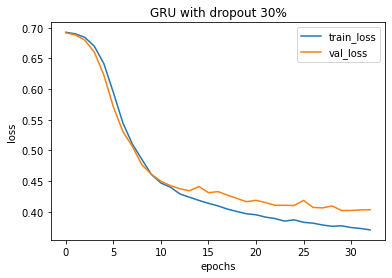

#########################################################################################################################
782/782 [==============================] - 3s 3ms/step - loss: 0.3863 - accuracy: 0.8271
Model 1 - LSTM Only =  [0.38628751039505005, 0.8270800113677979]
782/782 [==============================] - 5s 6ms/step - loss: 0.3810 - accuracy: 0.8275
Model 2 - LSTM with 2 layers & dropout 0.3 =  [0.3810323178768158, 0.8275200128555298]
782/782 [==============================] - 6s 6ms/step - loss: 0.3965 - accuracy: 0.8231
Model 3 - GRU (with 2 layers & dropout 0.3) = [0.39649608731269836, 0.8231199979782104]


In [12]:
## hidden layer add & 30%의 dropout을 적용
## 첫번째 은닉층의 계산값을 다음 층으로 전달해줘야 하므로, return_sequences=True
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(1000, 16, input_length = 100))
model3.add(keras.layers.GRU(8, dropout = 0.3, return_sequences=True))
model3.add(keras.layers.GRU(8, dropout = 0.3))
model3.add(keras.layers.Dense(1, activation = 'sigmoid'))
print( model3.summary() ) 
print('#########################################################################################################################')

model3.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = 'accuracy')
check_point_callback = keras.callbacks.ModelCheckpoint('best-GRU-model.h5', save_best_only=True)
early_stopping_callback = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history3 = model3.fit(train_seq, train_target, epochs = 100, batch_size = 64,
                    validation_data = (val_seq, val_target), 
                    callbacks = [check_point_callback, early_stopping_callback] )

print('#########################################################################################################################')
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('GRU with dropout 30%')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

print('#########################################################################################################################')
#test_seq = pad_sequences(test_input, maxlen = 100)
eval_model3 = keras.models.load_model('best-GRU-model.h5')
print('Model 1 - LSTM Only = ' , eval_model1.evaluate(test_seq, test_target))
print('Model 2 - LSTM with 2 layers & dropout 0.3 = ' , eval_model2.evaluate(test_seq, test_target))
print('Model 3 - GRU (with 2 layers & dropout 0.3) =' , eval_model3.evaluate(test_seq, test_target) )

- 이중 layer와 dropout을 사용한 model2가 가장 좋은 성능을 나타냈다. 
- 한편 GRU 또한 상대적으로 적은 계산량에도 불구 model2(LSTM)과 거의 유사한 결과를 보였다. 